In [1]:
import nrrd
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import os
import pandas as pd
from scipy import ndimage

In [2]:
os.getcwd()

'/app'

In [3]:
os.listdir()

['output.nii.gz',
 '.DS_Store',
 'requirements.txt',
 'Dockerfile',
 'source',
 'tests',
 'docs',
 '.ipynb_checkpoints',
 'data_transform.ipynb',
 'Data']

In [38]:
data_path = Path('Data/DIRU_2022_04_dog_03_E_nc')

In [39]:
os.listdir(data_path)

['03_E_nc_lat_meniscus_jointsmoothing0.75.seg.nrrd',
 '.DS_Store',
 'train_image_overlap.vtk',
 '03_E_nc_lat_meniscus_jointsmoothing0.75.vtk',
 'train_test_labelmap',
 'medialis',
 'test_image_overlap.vtk',
 'lateralis',
 'train_test_model',
 'TempWrite501 3D_VIEW_T2W_HR 0',
 '03_E_nc_lat_meniscus_jointsmoothing0.75-label_ColorTable.txt']

In [40]:
os.listdir(data_path/'medialis')

['03_E_nc_med_meniscus_raw.stl',
 '.DS_Store',
 '03_E_nc_med_Segmentation.seg.nrrd',
 '03_E_nc_med_meniscus_fillholes1mm.stl',
 '03_E_nc_med_meniscus_jointsmoothing0.75.stl']

In [41]:
os.listdir(data_path/'lateralis')

['.DS_Store',
 '03_E_nc_lat_Segmentation.seg.nrrd',
 '03_E_nc_lat_meniscus_fillholes1mm.stl',
 '03_E_nc_lat_meniscus_jointsmoothing0.75.stl',
 '03_E_nc_lat_meniscus_raw.stl']

In [44]:
# Load the NRRD file
data, header = nrrd.read(data_path/'medialis/03_E_nc_med_Segmentation.seg.nrrd')

# Create a NIfTI image
img = nib.Nifti1Image(data, np.eye(4))

# Save the image in NIfTI format
nib.save(img, 'output.nii.gz')

In [45]:
data.shape

(4, 560, 560, 484)

## Have a lookt at the header:

In [46]:
header

OrderedDict([('type', 'unsigned char'),
             ('dimension', 4),
             ('space', 'left-posterior-superior'),
             ('sizes', array([  4, 560, 560, 484])),
             ('space directions',
              array([[        nan,         nan,         nan],
                     [ 0.1425767 ,  0.00873998,  0.00191409],
                     [ 0.00210506, -0.00306444, -0.14280876],
                     [-0.01004412,  0.16465757, -0.00368134]])),
             ('kinds', ['list', 'domain', 'domain', 'domain']),
             ('encoding', 'gzip'),
             ('space origin',
              array([ -24.26164967, -148.45130192,   51.68599544])),
             ('Segment0_Color', '0.945098 0.839216 0.568627'),
             ('Segment0_ColorAutoGenerated', '1'),
             ('Segment0_Extent', '138 458 141 419 157 383'),
             ('Segment0_ID', 'Segment_2'),
             ('Segment0_LabelValue', '2'),
             ('Segment0_Layer', '0'),
             ('Segment0_Name', 'Cartilage')

## Have a look at data dimensions:

In [47]:
# Get the data from the image
data = img.get_fdata()

In [48]:
data.shape

(4, 560, 560, 484)

In [49]:
data[0, 0, :, :].shape

(560, 484)

## Have a look at the first slice: It is black because no signal is present:

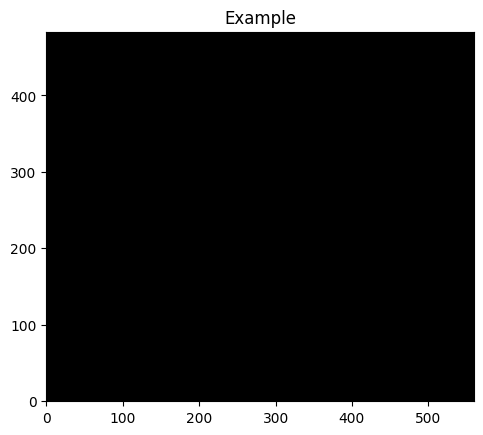

In [50]:
# Visualize a specific slice (e.g., the middle slice in the first dimension)
#slice_0 = data[data.shape[0]//2, 200, :, :]

slice_0 = data[0, 0, :, :]


# Plot the slice
plt.imshow(slice_0.T, cmap='gray', origin='lower')
plt.title('Example')
plt.show()

## Choose a channel for closer inspection as an example to get an idea:

It turns out channel 0 is the one that has meniscus as well as background signal:

In [139]:
data_ex = data[0, :, :, :]

## Find slices where signal is visible:

In [140]:
indices = []
max_vals = []
sum_vals = []
for ix in range(0, data_ex.shape[0]):
    
    max_val = np.max(data_ex[ix, :, :])
    sum_val = data_ex[ix, :, :].sum()
# Only choose indices of sclices with pixel-value bigger than 0,
    # i.e. where a signal is present:
    if max_val > 0:
        #print(ix)
        indices.append(ix)
        max_vals.append(max_val)
        sum_vals.append(sum_val)
        
indices_pixel_vals = pd.DataFrame({'index_value': indices, 'maximum': max_vals, 
             'pixel_sum': sum_vals})

indices_pixel_vals.head()

,index_value,maximum,pixel_sum
0,138,2.0,18.0
1,139,2.0,22.0
2,140,2.0,26.0
3,141,2.0,30.0
4,142,2.0,34.0


### Have a look at where the signal is the strongest:

<Axes: xlabel='index_value'>

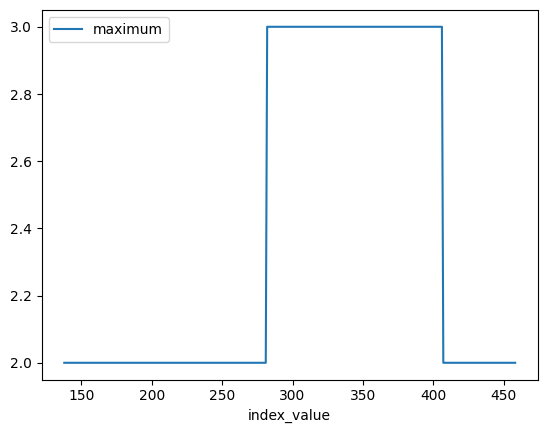

In [141]:
indices_pixel_vals.plot('index_value', 'maximum')

In [142]:
sel_bools = indices_pixel_vals.index_value > 250
indices_pixel_vals.loc[sel_bools]

,index_value,maximum,pixel_sum
113,251,2.0,97756.0
114,252,2.0,98164.0
115,253,2.0,98410.0
116,254,2.0,98960.0
117,255,2.0,99312.0
...,...,...,...
316,454,2.0,13520.0
317,455,2.0,10726.0
318,456,2.0,7826.0
319,457,2.0,5822.0


In [143]:
sel_bools = indices_pixel_vals.maximum > 2
selected_indices = indices_pixel_vals.loc[sel_bools]

In [144]:
selected_indices.head()

,index_value,maximum,pixel_sum
144,282,3.0,95720.0
145,283,3.0,96049.0
146,284,3.0,96030.0
147,285,3.0,96224.0
148,286,3.0,96992.0


In [145]:
selected_indices.tail()

,index_value,maximum,pixel_sum
264,402,3.0,89731.0
265,403,3.0,89686.0
266,404,3.0,89734.0
267,405,3.0,90354.0
268,406,3.0,90973.0


Select a few indices, where pictures will show:

In [146]:
indices_to_plot = list(np.arange(240, 440, 10))

In [147]:
np.max(data_ex[:, 270, :])

3.0

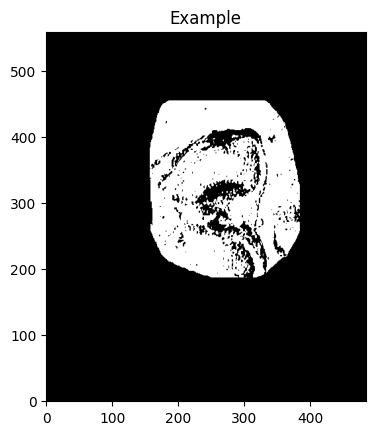

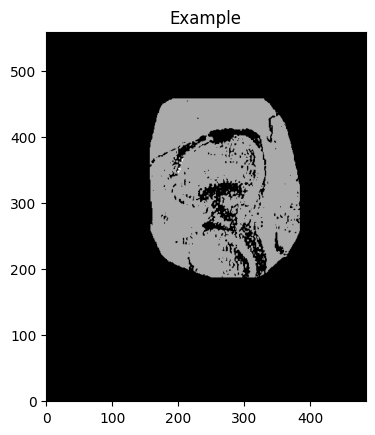

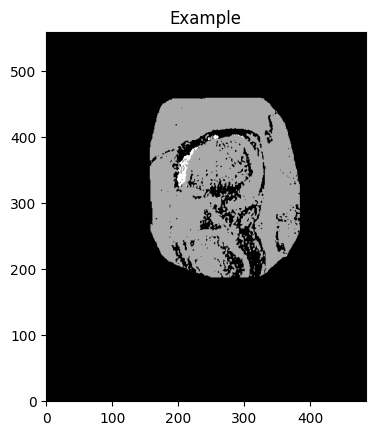

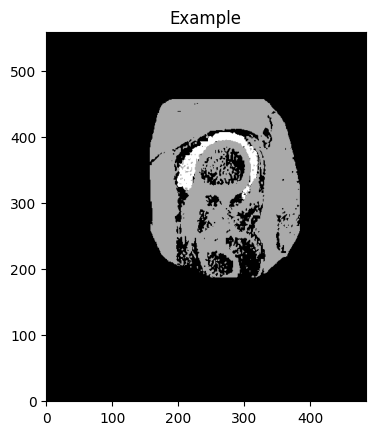

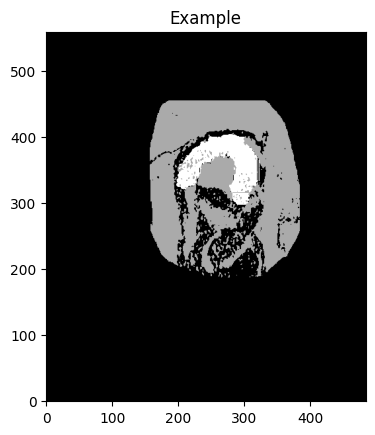

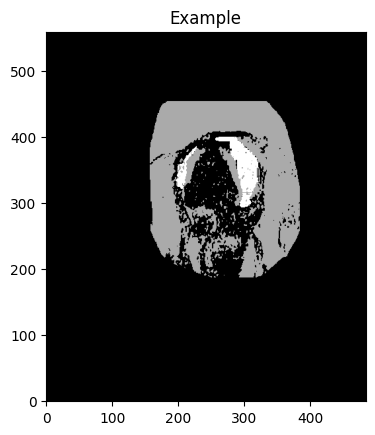

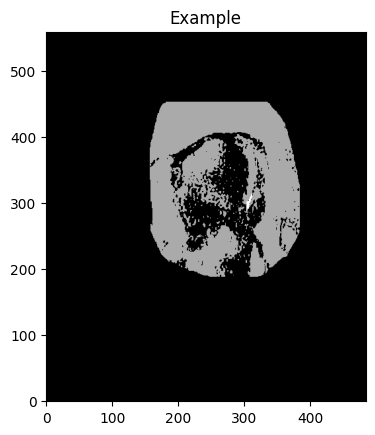

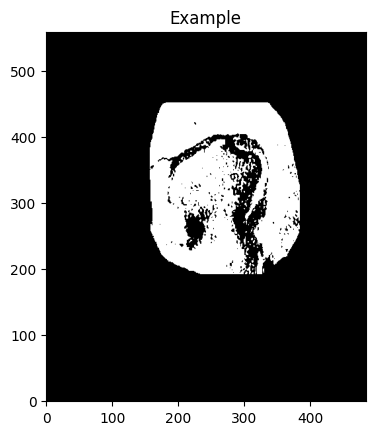

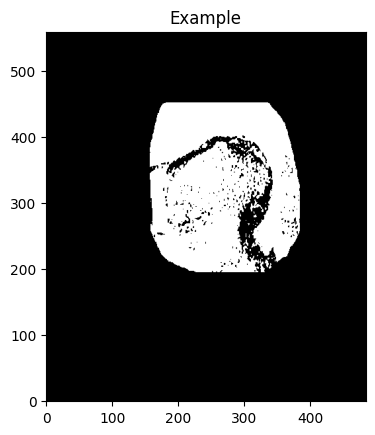

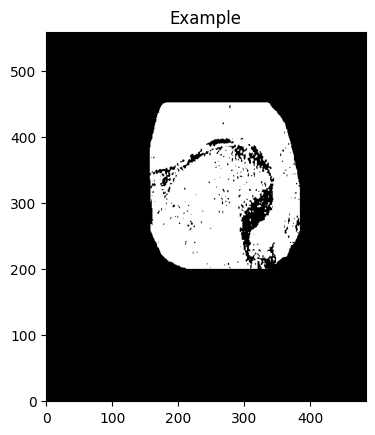

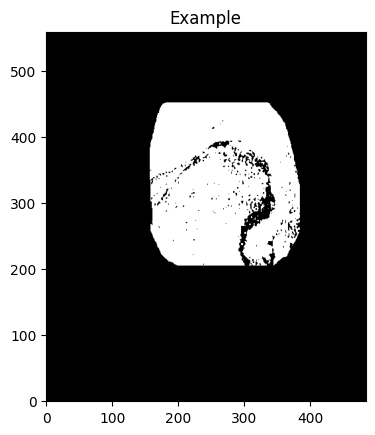

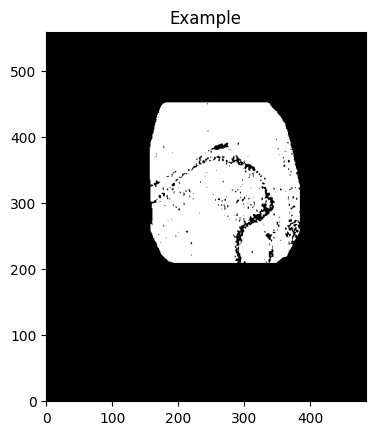

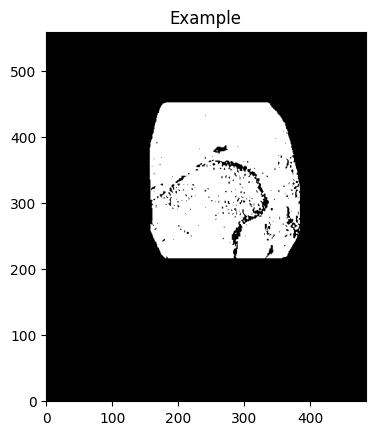

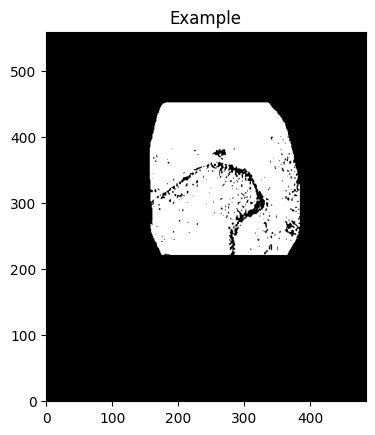

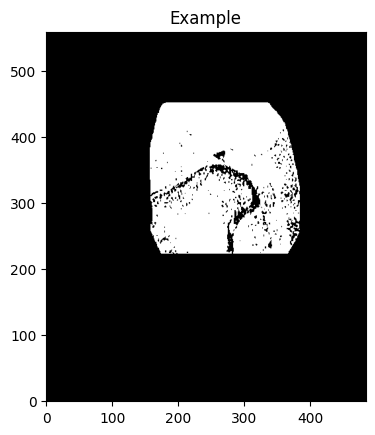

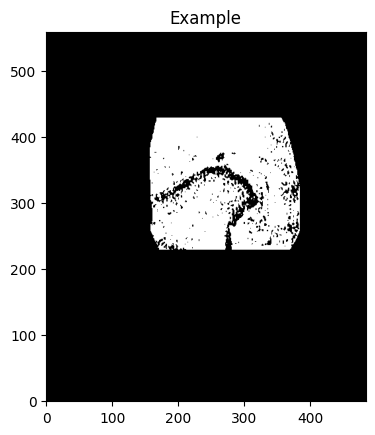

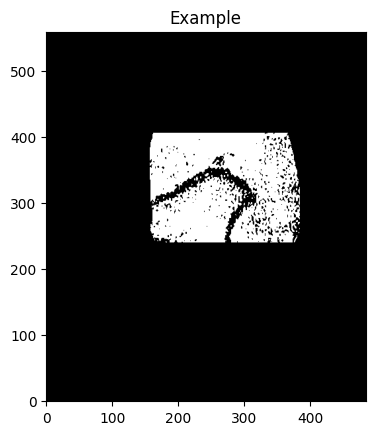

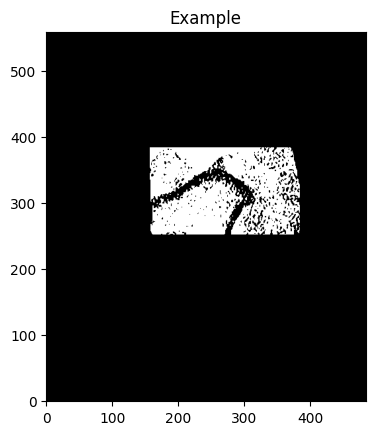

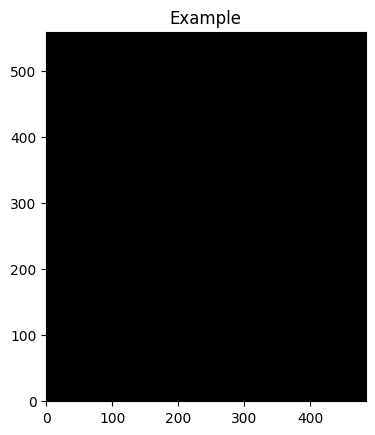

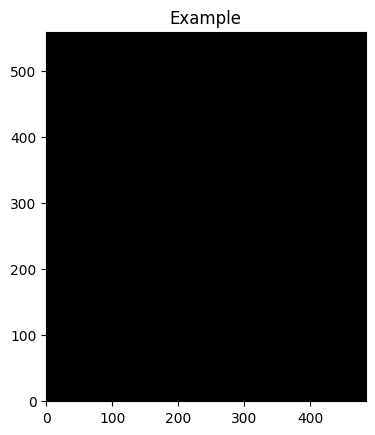

In [148]:
for ix in indices_to_plot:
    
    #slice_0 = data_ex[ix, :, :]
    slice_0 = data_ex[:, ix, :]
    #rotated_img = ndimage.rotate(slice_0, 5*60)
    
    # Plot the slice
    plt.imshow(slice_0, cmap='gray', origin='lower')
    plt.title('Example')
    plt.show()